In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
from utils.functions import load_data
from infopath.lick_classifier import prepare_classifier
from utils.functions import return_trial_type, pear_corr, explained, trial_metric, trial_type_perc
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from utils.plot_utils import plot_with_size, strip_right_top_axis, hit_miss_plot, retrieve_jaw_trial_type, pca_plot

import numpy as np
import torch
import os
%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)

/home/sourmpis/.conda/envs/trialmatch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sourmpis/.conda/envs/trialmatch/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sourmpis/.conda/envs/trialmatch/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but

In [2]:
os.chdir("..")

In [3]:
log_path = "log_dir/trained_models/main_model/"

In [4]:
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

In [5]:
(
    train_spikes,
    train_jaw,
    session_info_train,
    test_spikes,
    test_jaw,
    session_info_test,
) = load_data(model)

/home/sourmpis/lcn_server/sourmpis/Projects/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]
/home/sourmpis/lcn_server/sourmpis/Projects/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]


In [6]:
filt_jaw_train = model.filter_fun1(train_jaw) 
filt_jaw_test = model.filter_fun1(test_jaw) 
filt_data_train = model.filter_fun1(train_spikes) / model.timestep
filt_data_test = model.filter_fun1(test_spikes) / model.timestep
time_vector = torch.arange(int(np.round((model.opt.stop-model.opt.start)/opt.dt / 0.001)))*model.timestep + opt.start
filt_time = (
    model.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model.timestep
)[:, 0, 0] * model.timestep

lick_classifier = prepare_classifier(
    filt_jaw_train,
    filt_jaw_test,
    session_info_train,
    session_info_test,
    opt.device,
)

/tmp/ipykernel_1557888/2164605856.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model.timestep
100%|██████████| 150/150 [00:04<00:00, 30.47it/s, test_accuracy 0.944]


In [7]:
num_runs = 6 # for notm 12 last # for normal 11 last # for notrialoffset 5 best # for latent 4 best
trial_types_model = np.zeros((4, num_runs))
trial_types_model1 = np.zeros((4, num_runs))
test_loss, t_trial, perc_missmatch = [], [], []
for i in   range(0,num_runs): # [4]: # 
    print("seed: ", i)
    with torch.no_grad():
        seed = i
        batch_size = 200
        model.opt.batch_size = batch_size
        torch.cuda.empty_cache()
        torch.manual_seed(i)
        all_stims = torch.zeros(batch_size)
        all_stims[:int(batch_size/2)] = 1
        stims = all_stims[torch.randperm(all_stims.shape[0])]
        stims = torch.tensor(stims, device=opt.device)

        state = model.steady_state()
        input_spikes = model.input_spikes(stims)
        model.rsnn.sample_mem_noise(
            input_spikes.shape[0], input_spikes.shape[1]
        )
        mem_noise = model.rsnn.mem_noise.clone()
        model_spikes, voltages, model_jaw, state = model.step(
            input_spikes, state, mem_noise=mem_noise
        )
        filt_model= model.filter_fun1(model_spikes) / model.timestep
        filt_jaw = model.filter_fun1(model_jaw) 
        
    trial_type_pred_lick, model_perc = return_trial_type(
        model,
        filt_data_train,
        filt_model,
        filt_jaw_train,
        filt_jaw,
        session_info_train,
        stims,
        lick_classifier,
    )
    
    trial_types_model1[:,i] = model_perc.cpu().numpy()
    print("lick based: ", model_perc)

    trial_type_pred, model_perc = return_trial_type(
        model,
        filt_data_train,
        filt_model,
        filt_jaw_train,
        filt_jaw,
        session_info_train,
        stims,
        None,
    )
    trial_types_model[:,i] = model_perc.cpu().numpy()

    print("template matching:", model_perc)#, trial_type_pred_spikes.unique())
    
    licks = torch.zeros(batch_size).to(model_spikes[0].device)
    thr = 2
    licks[stims>0] = (filt_jaw[filt_time>1,:,0][:,stims>0.5].max(0)[0] > thr)*1.
    licks[stims==0] = (filt_jaw[filt_time>1,:,0][:,stims<0.5].max(0)[0] > thr)*1.
    tt = (1-stims) * 2 +  licks
    perc = tt.unique(return_counts=True)[1]/tt.shape[0]
    print("threshold based: ", perc)


/tmp/ipykernel_1557888/2777201824.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stims = torch.tensor(stims, device=opt.device)


seed:  0
lick based:  tensor([0.2150, 0.2850, 0.4100, 0.0900])
template matching: tensor([0.1100, 0.2750, 0.4350, 0.1800])
threshold based:  tensor([0.2050, 0.2950, 0.3550, 0.1450])
seed:  1
lick based:  tensor([0.1650, 0.3350, 0.4200, 0.0800])
template matching: tensor([0.0950, 0.3250, 0.4250, 0.1550])
threshold based:  tensor([0.1550, 0.3450, 0.3700, 0.1300])
seed:  2


lick based:  tensor([0.1800, 0.3200, 0.4200, 0.0800])
template matching: tensor([0.0800, 0.3450, 0.4150, 0.1600])
threshold based:  tensor([0.1700, 0.3300, 0.3450, 0.1550])
seed:  3
lick based:  tensor([0.1950, 0.3050, 0.3950, 0.1050])
template matching: tensor([0.0700, 0.3000, 0.4150, 0.2150])
threshold based:  tensor([0.1450, 0.3550, 0.3450, 0.1550])
seed:  4
lick based:  tensor([0.2300, 0.2700, 0.4100, 0.0900])
template matching: tensor([0.1200, 0.3250, 0.4000, 0.1550])
threshold based:  tensor([0.2100, 0.2900, 0.3650, 0.1350])
seed:  5
lick based:  tensor([0.1650, 0.3350, 0.4250, 0.0750])
template matching: tensor([0.0900, 0.3200, 0.4350, 0.1550])
threshold based:  tensor([0.1350, 0.3650, 0.4000, 0.1000])


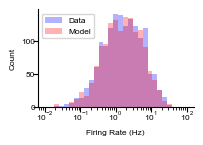

In [8]:
# Figure 3 B
# baseline firing rates, before any stimulation

firing_rates_data = model.firing_rate
start = int(-opt.start / model.timestep)
firing_rates_model = model_spikes[:start].mean((0,1)) / model.timestep
firing_rates_model = firing_rates_model.cpu().numpy()

fig, ax = plot_with_size(40,25)
bins = np.linspace(-2, 2, 30)
bins = 10**bins
ax.hist(firing_rates_data, bins=bins, alpha=0.3, label="Data", color="blue")
ax.hist(firing_rates_model, bins=bins, alpha=0.3, label="Model", color="red")
plt.xscale("log")
strip_right_top_axis(ax)
ax.set_ylabel("Count")
ax.set_xlabel("Firing Rate (Hz)")
ax.tick_params(axis="both", which="major", pad=-2)
ax.legend()
fig.savefig("Figures/Figure3/firing_rates.pdf")

In [9]:
# we repeat the process for the case without trial matching,
# unfortunately the model that we rerun without trial matching had different initialization so we need to rerun everything
log_path_notm = "log_dir/trained_models/no_trialmatching_model/"
opt_notm = load_training_opt(log_path_notm)
opt_notm.log_path = log_path_notm
opt_notm.device = "cpu"
model_notm = load_model_and_optimizer(opt_notm, reload=True, last_best="last")[0]
(
    train_spikes_notm,
    train_jaw_notm,
    session_info_train_notm,
    test_spikes_notm,
    test_jaw_notm,
    session_info_test_notm,
) = load_data(model_notm)
filt_jaw_train_notm = model.filter_fun1(train_jaw_notm) 
filt_jaw_test_notm = model.filter_fun1(test_jaw_notm) 
filt_data_train_notm = model.filter_fun1(train_spikes_notm) / model.timestep
filt_data_test_notm = model.filter_fun1(test_spikes_notm) / model.timestep

lick_classifier = prepare_classifier(
    filt_jaw_train_notm,
    filt_jaw_test_notm,
    session_info_train_notm,
    session_info_test_notm,
    opt.device,
)

/home/sourmpis/lcn_server/sourmpis/Projects/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]
/home/sourmpis/lcn_server/sourmpis/Projects/TrialMatching/datasets/dataloader.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_info = trial_info[(lick_trials & reaction_time) | no_lick_trials]
100%|██████████| 150/150 [00:04<00:00, 30.31it/s, test_accuracy 0.941]


In [10]:
num_runs = 6
trial_types_model_notm = np.zeros((4, num_runs))
trial_types_model1_notm = np.zeros((4, num_runs))
test_loss, t_trial, perc_missmatch = [], [], []
for i in   range(0,num_runs):
    print("seed: ", i)
    with torch.no_grad():
        seed = i
        batch_size = 200
        model_notm.opt.batch_size = batch_size
        torch.cuda.empty_cache()
        torch.manual_seed(i)
        all_stims = torch.zeros(batch_size)
        all_stims[:int(batch_size/2)] = 1
        stims = all_stims[torch.randperm(all_stims.shape[0])]
        stims = torch.tensor(stims, device=opt.device)

        state = model_notm.steady_state()
        input_spikes = model_notm.input_spikes(stims)
        model_notm.rsnn.sample_mem_noise(
            input_spikes.shape[0], input_spikes.shape[1]
        )
        mem_noise = model_notm.rsnn.mem_noise.clone()
        model_spikes_notm, voltages, model_jaw_notm, state = model_notm.step(
            input_spikes, state, mem_noise=mem_noise
        )
        filt_model_notm= model_notm.filter_fun1(model_spikes_notm) / model_notm.timestep
        filt_jaw_notm = model_notm.filter_fun1(model_jaw_notm) 
        
    trial_type_pred_lick_notm, model_perc = return_trial_type(
        model_notm,
        filt_data_train_notm,
        filt_model_notm,
        filt_jaw_train_notm,
        filt_jaw_notm,
        session_info_train_notm,
        stims,
        lick_classifier,
    )
    
    trial_types_model1_notm[:,i] = model_perc.cpu().numpy()
    print("lick based: ", model_perc)

    trial_type_pred_lick_notm, model_perc = return_trial_type(
        model_notm,
        filt_data_train_notm,
        filt_model_notm,
        filt_jaw_train_notm,
        filt_jaw_notm,
        session_info_train_notm,
        stims,
        None,
    )
    trial_types_model_notm[:,i] = model_perc.cpu().numpy()

    print("template matching:", model_perc)#, trial_type_pred_spikes.unique())
    
    licks = torch.zeros(batch_size).to(model_spikes[0].device)
    thr = 2
    licks[stims>0] = (filt_jaw[filt_time>1,:,0][:,stims>0.5].max(0)[0] > thr)*1.
    licks[stims==0] = (filt_jaw[filt_time>1,:,0][:,stims<0.5].max(0)[0] > thr)*1.
    tt = (1-stims) * 2 +  licks
    perc = tt.unique(return_counts=True)[1]/tt.shape[0]
    print("threshold based: ", perc)


/tmp/ipykernel_1557888/3887385733.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stims = torch.tensor(stims, device=opt.device)


seed:  0
lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2500, 0.4850, 0.2650])
threshold based:  tensor([0.2250, 0.2750, 0.3100, 0.1900])
seed:  1


lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2650, 0.4650, 0.2700])
threshold based:  tensor([0.2450, 0.2550, 0.2900, 0.2100])
seed:  2
lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2300, 0.5250, 0.2450])
threshold based:  tensor([0.2850, 0.2150, 0.2500, 0.2500])
seed:  3
lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2500, 0.5300, 0.2200])
threshold based:  tensor([0.2650, 0.2350, 0.2700, 0.2300])
seed:  4
lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2600, 0.4900, 0.2500])
threshold based:  tensor([0.2850, 0.2150, 0.2500, 0.2500])
seed:  5
lick based:  tensor([0.5000, 0.0000, 0.5000, 0.0000])
template matching: tensor([0.0000, 0.2350, 0.5550, 0.2100])
threshold based:  tensor([0.1350, 0.3650, 0.4000, 0.1000])


0.3140556 0.30180085 0.29139146 Ttest_indResult(statistic=1.03209031586573, pvalue=0.3021602031975834)
0.008562792145079993 0.008216842823191722 0.008269072540344731


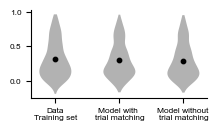

In [11]:
torch.manual_seed(0)
trials = torch.randperm(batch_size)[:200]
psth_model = (filt_model[:,trials].nanmean(1).T) / model.timestep
psth_data_train = (filt_data_train.nanmean(1).T) / model.timestep
psth_data_test = (filt_data_test.nanmean(1).T) / model.timestep
psth_model_notm = (filt_model_notm[:,trials].nanmean(1).T) / model.timestep
psth_data_test_notm = (filt_data_test_notm.nanmean(1).T) / model.timestep

psth_model_notm = psth_model_notm[model_notm.firing_rate>1]
psth_data_test_notm = psth_data_test_notm[model_notm.firing_rate>1]
psth_model = psth_model[model.firing_rate>1]
psth_data_train = psth_data_train[model.firing_rate>1]
psth_data_test = psth_data_test[model.firing_rate>1]

p_corr_notm = pear_corr(psth_data_test_notm, psth_model_notm, dim=1, eps=1e-7)
p_corr = pear_corr(psth_data_test, psth_model, dim=1, eps=1e-7)
p_corr_train = pear_corr(psth_data_train, psth_data_test,dim=1, eps=1e-7)
std_train = p_corr_train.std()/p_corr_train.shape[0]**0.5
std = p_corr.std()/p_corr.shape[0]**0.5
print(p_corr_train.mean(), p_corr.mean(), p_corr_notm.mean(), ttest_ind(p_corr_train, p_corr))
print(p_corr_train.std()/p_corr_train.shape[0]**0.5, p_corr.std()/p_corr.shape[0]**0.5,   p_corr_notm.std()/p_corr_notm.shape[0]**0.5)


r2_fun = lambda x, y : 1-((x-y)**2).mean(1) / ((y.T - y.mean(1))**2).T.mean(1)
r2 = explained(psth_data_test, psth_model, dim=1, eps=1e-7)
r2_train = explained(psth_data_train, psth_data_test,dim=1, eps=1e-7)

with plt.rc_context({"font.size":6}):
    fig, ax = plot_with_size(45, 22.5)
    violin1 = ax.violinplot([p_corr_train], positions=[0], showextrema=False)
    violin2 = ax.violinplot([p_corr], positions=[1], showextrema=False)
    violin3 = ax.violinplot([p_corr_notm], positions=[2], showextrema=False)
    violin1["bodies"][0].set_facecolor("black")
    violin2["bodies"][0].set_facecolor("black")
    violin3["bodies"][0].set_facecolor("black")
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["Data\nTraining set", "Model with \ntrial matching", "Model without \ntrial matching"],)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.scatter([0, 1, 2], [p_corr_train.mean(), p_corr.mean(), p_corr_notm.mean()], color="black", s=10)
    fig.savefig(f"Figures/Figure3/t_neuron_pearson.pdf")

0.5300477 0.4962765 0.256801 Ttest_indResult(statistic=4.265650486040116, pvalue=2.0538826726633873e-05)
0.00542901609735923 0.0057587998896637795 0.0033747907572445686


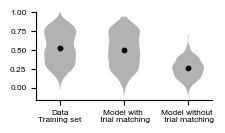

In [12]:
torch.manual_seed(0)
p_corr_train = trial_metric(
    model.filter_fun2(filt_data_train), 
    model.filter_fun2(filt_data_test), 
    model.filter_fun2(filt_jaw_train), 
    model.filter_fun2(filt_jaw_test), 
    session_info_train, 
    model, 
    pear_corr,
)
p_corr = trial_metric(
    model.filter_fun2(filt_data_test), 
    model.filter_fun2(filt_model),
    model.filter_fun2(filt_jaw_test), 
    model.filter_fun2(filt_jaw), 
    session_info_train, 
    model, 
    pear_corr,
)

p_corr_notm = trial_metric(
    model_notm.filter_fun2(filt_data_test_notm), 
    model_notm.filter_fun2(filt_model_notm),
    model_notm.filter_fun2(filt_jaw_test_notm), 
    model_notm.filter_fun2(filt_jaw_notm), 
    session_info_train_notm, 
    model_notm, 
    pear_corr,
)
print(p_corr_train.mean(), p_corr.mean(), p_corr_notm.mean(), ttest_ind(p_corr_train, p_corr))
print(p_corr_train.std()/p_corr_train.shape[0]**0.5, p_corr.std()/p_corr.shape[0]**0.5, p_corr_notm.std()/p_corr_notm.shape[0]**0.5)
std_train = p_corr_train.std()/p_corr_train.shape[0]**0.5
std =  p_corr.std()/p_corr.shape[0]**0.5
with plt.rc_context({"font.size":6}):
    fig, ax = plot_with_size(45, 22.5)
    violin1 = ax.violinplot([p_corr_train], positions=[0], showextrema=False)
    violin2 = ax.violinplot([p_corr], positions=[1], showextrema=False)
    violin3 = ax.violinplot([p_corr_notm], positions=[2], showextrema=False)
    violin1["bodies"][0].set_facecolor("black")
    violin2["bodies"][0].set_facecolor("black")
    violin3["bodies"][0].set_facecolor("black")
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["Data\nTraining set", "Model with \n trial matching", "Model without \n trial matching"],)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.scatter([0, 1, 2], [p_corr_train.mean(), p_corr.mean(), p_corr_notm.mean()], color="black", s=10)
    ax.set_ylim(-0.16, 1)
    fig.savefig(f"Figures/Figure3/t_trial_pearson.pdf")


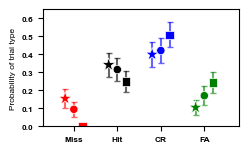

In [13]:
# Figure 4 A

data_perc = trial_type_perc(
    session_info_train, num_trial_types=len(opt.trial_types)
)
color = ["red","black","blue","green"]
with plt.rc_context({"font.size":6, "font.weight":"bold"}):
    fig, ax = plot_with_size(50, 30)
    perc_data_mean = data_perc
    tt_data_std = ((1 - perc_data_mean) * perc_data_mean)**0.5 # trial_types.std(1) #
    perc_95inter = 1.96 * tt_data_std / (194) ** 0.5 #28**0.5
    for i, c in enumerate(color):
        ax.errorbar(i, perc_data_mean[i], perc_95inter[i], capsize=2, linestyle="",color=color[i], alpha=0.6, zorder=0)
    ax.scatter(np.arange(4), perc_data_mean,marker="*", s=100,color=color, edgecolors="white", linewidths=0.5,zorder=1)

    perc_model_mean = trial_types_model.mean(1)
    tt_model_std = ((1 - perc_model_mean) * perc_model_mean)**0.5 # tt_model.std(1) # 
    perc_model_95inter = 1.96 * tt_model_std / batch_size**0.5#tt_model.shape[1]**0.5
    for i, c in enumerate(color):
        ax.errorbar(i+0.2, perc_model_mean[i], perc_model_95inter[i], capsize=2, linestyle="",color=color[i], alpha=0.6,zorder=0) 
    ax.scatter(np.arange(4)+0.2, perc_model_mean,color=color, edgecolors="white",zorder=1, linewidths=0.5)
    
    perc_model_mean = trial_types_model_notm.mean(1)
    tt_model_std = ((1 - perc_model_mean) * perc_model_mean)**0.5 
    perc_model_95inter = 1.96 * tt_model_std / batch_size**0.5
    for i, c in enumerate(color):
        ax.errorbar(i+0.4, perc_model_mean[i], perc_model_95inter[i], capsize=2, linestyle="",color=color[i], alpha=0.6,zorder=0)
    ax.scatter(np.arange(4)+0.4, perc_model_mean, marker="s", color=color, edgecolors="white",zorder=1, linewidths=0.5)
    ax.set_xticks([0.2,1.2,2.2,3.2])
    ax.set_xticklabels(["Miss", "Hit", "CR", "FA"])
    ax.set_ylim(0, 0.65)
    ax.set_xlim(-0.5, 4)
    ax.set_ylabel("Probability of trial type")
    fig.savefig(f"Figures/Figure4/figure4a.pdf")